<a href="https://colab.research.google.com/github/EiffL/AstroHackWeek2019/blob/master/day4_ml/UnderstandingLossFunctions_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

## Understanding Regression Loss Functions And Introduction to TensorFlow Probability

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

In this short notebook, we will try to solve a simple regression problem where 
the error distribution is unknown, and in particular heteroscedastic and asymetric. This will teach us about what information is recovered by different 
usual regression loss functions like mean absolute error and mean square error losses. And finally, we will see that using [TensorFlow Probability](https://www.tensorflow.org/probability) (TFP) we can model 
a full posterior probability and extract any summary we want from it.

### Learning goals

In this notebook, we will learn:
*   The probabilistic interpretation of common regression loss functions
*   How to use TFP for modelling distributions in Keras
*   How to build and use a Mixture Density Network



In [2]:
#@title Imports { display-mode: "form" }
%pylab inline
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

Populating the interactive namespace from numpy and matplotlib
SUCCESS: Found GPU: /device:GPU:0


If the GPU fails to load, activate the GPU hardware acceleration in `Runtime > Change Runtime Type`

## Generating some data

We begin by generating some data sampled from a distribution $p(y | x)$ constructed from a log normal distribution with 

log normal distribution with position and sigma 

In [0]:
from scipy.stats import lognorm

x = linspace(0.1,1.5)
def model(x):
  return lognorm.rvs(s=x, loc=2*x)

(0, 12)

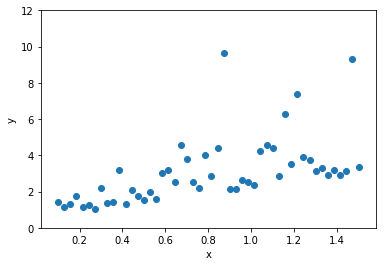

In [15]:
scatter(x, model(x))
xlabel('x')
ylabel('y')
ylim(0,12);

The task will be:
```
Given this data, solve a regression problem and estimate y given x.
```
As we will see in this notebook, this is not well defined at all ;-) There is no
single answer, the problem is degenerate, for a given $x$ there is actually a full distribution of possible $y$. What is regression in this context, do we mean the mean, the mode, or the median of $p(y | x)$, and if so, how do we estimate them?

Text(0, 0.5, 'y')

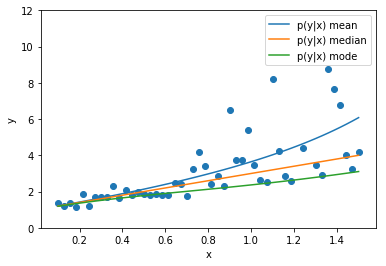

In [56]:
scatter(x, model(x))
plot(x, lognorm.mean(x, loc=2*x), label='p(y|x) mean')
plot(x, lognorm.median(x, loc=2*x), label='p(y|x) median')
plot(x, exp(- x**2) + 2*x, label='p(y|x) mode')
ylim(0,12)
legend()
xlabel('x')
ylabel('y')

In [0]:
# Building training and testing sets 
x_train = np.random.uniform(0.1,1.5,100*1000).reshape(1000,100)
y_train = model(x_train)

x_test = np.random.uniform(0.1,1.5,100*1000).reshape(1000,100)
y_test = model(x_test)

## Exercise 1: Regression with l1 and l2 losses

In this first exercise, let's attempt a standard regression. We begin with the 
usual mean squared error, a.k.a. l2 loss $\mathcal{L} = \parallel y - f_\varphi(x) \parallel_2^2$.
Here is a simple Keras model using an l2 loss for the regressoin:


In [0]:
import tensorflow.keras as keras

learning_rate=1e-3
decay=1e-6

l2_model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(1,)),
    keras.layers.Dense(units=128, activation='tanh'),
    keras.layers.Dense(units=1)
])

opt = keras.optimizers.Adam(lr=learning_rate, decay=decay)

l2_model.compile(loss='mean_squared_error', optimizer=opt)

In [26]:
# Train the model
l2_model.fit(x_train.flatten(), y_train.flatten(), batch_size=256, epochs=20)

Epoch 1/20
100000/100000 [==============================] - 1s 11us/sample - loss: 8.9712
Epoch 2/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6742
Epoch 3/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6647
Epoch 4/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6647
Epoch 5/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6548
Epoch 6/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6539
Epoch 7/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6626
Epoch 8/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6541
Epoch 9/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6577
Epoch 10/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6545
Epoch 11/20
100000/100000 [==============================] - 1s 10us/sample - loss: 8.6578
Epoch 12

In [0]:
# Evaluate the regression model on the testing set
preds = l2_model.predict(x_test.flatten())
preds = preds.reshape(y_test.shape)

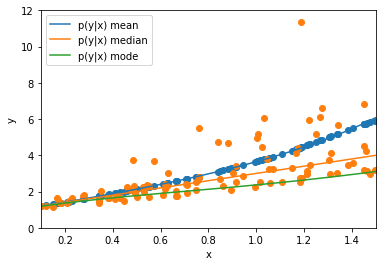

In [30]:
scatter(x_test[0], preds[0])
scatter(x_test[0], y_test[0])
xlabel('x')
ylabel('y')
xlim(0.1,1.5)
ylim(0,12)
plot(x, lognorm.mean(x, loc=2*x), label='p(y|x) mean')
plot(x, lognorm.median(x, loc=2*x), label='p(y|x) median')
plot(x, exp(- x**2) + 2*x, label='p(y|x) mode')
legend()

Interesting! Turns out that the mean squared error actually leads to estimating  the mean of the distribution $p(y | x)$. As we see here, the mean is not always a great summary of the distribution, it is heavily influenced by the tails of the distribution and can become very different from the mode.

**Homework**: Show analytically that MSE regression correponds to estimating the posterior mean.

Now, let's do the same thing but with the mean absolute error, a.k.a. l1 loss $\mathcal{L} = |y - f(x)|$.

In [0]:
import tensorflow.keras as keras

learning_rate=1e-3
decay=1e-6

l1_model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(1,)),
    keras.layers.Dense(units=128, activation='tanh'),
    keras.layers.Dense(units=1)
])

opt = keras.optimizers.Adam(lr=learning_rate, decay=decay)

l1_model.compile(loss='mean_absolute_error', optimizer=opt)

In [35]:
l1_model.fit(x_train.flatten(), y_train.flatten(), batch_size=256, epochs=20)

Epoch 1/20
100000/100000 [==============================] - 2s 20us/sample - loss: 1.0147
Epoch 2/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9863
Epoch 3/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9860
Epoch 4/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9859
Epoch 5/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9853
Epoch 6/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9854
Epoch 7/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9852
Epoch 8/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9861
Epoch 9/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9856
Epoch 10/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9860
Epoch 11/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.9849
Epoch 12

In [0]:
# Evaluate the regression model on the testing set
preds = l1_model.predict(x_test.flatten())
preds = preds.reshape(y_test.shape)

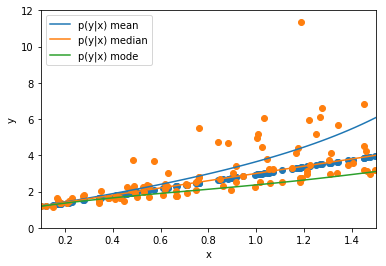

In [37]:
scatter(x_test[0], preds[0])
scatter(x_test[0], y_test[0])
xlabel('x')
ylabel('y')
xlim(0.1,1.5)
ylim(0,12)
plot(x, lognorm.mean(x, loc=2*x), label='p(y|x) mean')
plot(x, lognorm.median(x, loc=2*x), label='p(y|x) median')
plot(x, exp(- x**2) + 2*x, label='p(y|x) mode')
legend()

Bang on on the median! So the lesson here is that minimizing the mean absolute error leads to estimating the median of the distribution $p(y | x)$. This can be more robust than l2 regression, the median is more robust to outliers and ends up being much closer to the mode of the distribution.


**Homework**: Show analytically that MAE regression correponds to estimating the posterior median.

## Exercise 2: Switch to Probabilistic Modelling

What we have seen in the previous exercise is that different choices of regression loss functions lead to different point estimate summaries of a full distribution $p(y|x)$. But in a complex case like this one, the mode of the distribution is different from both mean and median, so how to get to it?

Also, we are starting to see that summaries do not give a full picture of the problem. Let's try to actually learn the full posterior with TensorFlow Probability.

The  first thing we need is a parametric model for the distribution $q_{\varphi}(y|x)$ that the model will be predicting. A simple approach to build a flexible
distribution is to use a Gaussian Mixture Density. With TensorFlow Probability this is easily done by adding a `tfp.layers.MixtureNormal` as the last layer of the model. Check out the documentation here: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/MixtureNormal


In [0]:
import tensorflow.keras as keras
import tensorflow_probability as tfp

learning_rate=1e-3
decay=1e-6

# Number of components in the Gaussian Mixture
num_components = 16
# Shape of the distribution
event_shape = [1]
# Utility function to compute how many parameters this distribution requires
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)

gmm_model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(1,)),
    keras.layers.Dense(units=128, activation='tanh'),
    keras.layers.Dense(params_size),
    tfp.layers.MixtureNormal(num_components, event_shape)
])

An important thing to note is that now the model doesn't just return a number, it returns a full distribution object:

In [47]:
# We reshape x to match the event size of 1
gmm_model(x_test.reshape((-1,1)))

<tfp.distributions.MixtureSameFamily 'sequential_5/mixture_normal_1/MixtureSameFamily/MixtureSameFamily/' batch_shape=[100000] event_shape=[1] dtype=float32>

This distribution object can be used to sample from the model, or evaluate the log probability of the model.

Now that we have a model, let's train it. For that we need to define the loss function for Keras, which will be based on the negative log likelihood:

In [0]:
# Note that Keras will call this loss function with two arguments, the data
# point y, and the distribution q(y | x) predicted as the output of the model
negloglik = lambda y, q: -q.log_prob(y)

opt = keras.optimizers.Adam(lr=learning_rate, decay=decay)

gmm_model.compile(loss=negloglik, optimizer=opt)

In [49]:
gmm_model.fit(x_train.reshape((-1,1)), y_train.reshape((-1,1)), batch_size=256, epochs=20)

Epoch 1/20
100000/100000 [==============================] - 1s 14us/sample - loss: 1.9592
Epoch 2/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.1445
Epoch 3/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0845
Epoch 4/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0672
Epoch 5/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0632
Epoch 6/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0570
Epoch 7/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0549
Epoch 8/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0533
Epoch 9/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0526
Epoch 10/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0513
Epoch 11/20
100000/100000 [==============================] - 1s 13us/sample - loss: 1.0533
Epoch 12

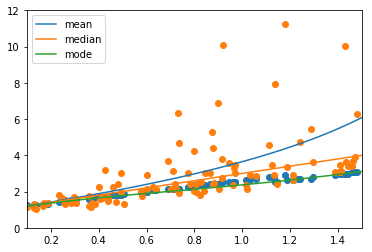

In [53]:
# Find the mode by sampling the pdf
x_smpl = linspace(0.5,5,50)

# We evaluate the log probability of the model at different points, to sample the pdf of
# each example
preds = np.stack([gmm_model(x_test.reshape((-1,1))).log_prob(x).numpy() for x in x_smpl])
mode = x_smpl[preds.argmax(axis=0)]
mode = mode.reshape(y_test.shape)

scatter(x_test[1], mode[1])
scatter(x_test[1], y_test[1])

xlim(0.1,1.5)
ylim(0,12)

plot(x, lognorm.mean(x, loc=2*x), label='mean')
plot(x, lognorm.median(x, loc=2*x), label='median')
plot(x, exp(- x**2) + 2*x, label='mode')
legend()

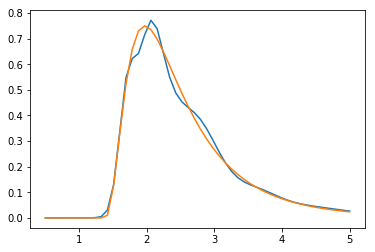

In [55]:
# We can also have a look at individual example pdfs
plot(x_smpl, exp(preds[:,2]))
plot(x_smpl, lognorm.pdf(x_smpl, s=x_test.flatten()[2], loc=2*x_test.flatten()[2]))

## Conclusion

As soon as the data contains uncertainties, the solution to a regression problem is not something well defined. As we have seen, classical loss functions
allow us to estimate summaries of the full problem posterior, but this has its limits when that posterior is not trivial.

Using a distribution as the output of the model allows us model the full problem posterior, which can then be manipulated to locate the mode, or derive confidence intervals! And all we did was to add one TFP layer to the model!